In [87]:

# We can optimize the path to visit all 472 subway stations in the New York City subway system, so that a very ambitious person can visit all
# the stations in the entire system, in minimum time. I looked around for a while for a file that has all 472 subway stations as well as latitude +
# longitue coordinates for each station. I found some data that had a bunch of station names, but no lat/lon coordinates. I found a file that had 
# different lat/lon coordinates for the same sattion. The API call below gives us access to 60 stations, which seems to be a hard limit.
# Although this doesn't demonstrate how to get all data for all 472 subway stations, I made it very dynamic, so if you can find a file that has all
# 472 stations, with station_name lat, lon, you can easily substitute that data for the data I'm showing here.


In [2]:

# There is a limit of 60 records when hitting this API endpoint. You should be able to get more than this, I think. Myabe there is an optinon
# to pay and get more data. I'm not sure how this works.

import requests
import pandas as pd
import time

# Your Google Maps API key
API_KEY = 'your_api_key'

# Define the location and search radius
location = '40.7128,-74.0060'  # Coordinates for New York City
radius = 10000  # Radius in meters

# Define the search type and keyword
place_type = 'subway_station'

# Function to get nearby places with pagination
def get_nearby_places(location, radius, place_type, api_key):
    url = f"https://maps.googleapis.com/maps/api/place/nearbysearch/json"
    params = {
        'location': location,
        'radius': radius,
        'type': place_type,
        'key': api_key
    }
    results = []
    while True:
        response = requests.get(url, params=params)
        data = response.json()
        results.extend(data['results'])
        # Check if there is another page of results
        if 'next_page_token' not in data:
            break
        # Use the next_page_token for the next request
        params['pagetoken'] = data['next_page_token']
        # Google Places API requires a pause before making the next request
        time.sleep(2)  # Adjust this delay as per Google's recommendations (minimum of 2 seconds)
    return results

# Function to get place details
def get_place_details(place_id, api_key):
    url = f"https://maps.googleapis.com/maps/api/place/details/json"
    params = {
        'place_id': place_id,
        'key': api_key
    }
    response = requests.get(url, params=params)
    result = response.json().get('result', {})
    return result

# Get nearby subway stations
subway_stations = get_nearby_places(location, radius, place_type, API_KEY)

# Extract details for each station
stations_data = []
for station in subway_stations:
    place_id = station['place_id']
    details = get_place_details(place_id, API_KEY)
    stations_data.append({
        'name': details.get('name'),
        'lat': details.get('geometry', {}).get('location', {}).get('lat'),
        'lng': details.get('geometry', {}).get('location', {}).get('lng'),
        'address': details.get('formatted_address'),
        'place_id': place_id
    })

# Convert to DataFrame
stations_df = pd.DataFrame(stations_data)
print(stations_df.shape)
print(stations_df.tail())


(60, 5)
                          name        lat        lng  \
55              W 4 St-Wash Sq  40.732338 -74.000496   
56                    8 St-NYU  40.730636 -73.992379   
57  Christopher St-Sheridan Sq  40.733659 -74.003011   
58                    Court St  40.694016 -73.991440   
59                Borough Hall  40.693771 -73.990433   

                                 address                     place_id  
55  340 6th Ave, New York, NY 10011, USA  ChIJTbWiV5FZwokRsywIOc28k3Q  
56               New York, NY 10003, USA  ChIJdds5RppZwokR0fZVTlTGzdQ  
57               New York, NY 10014, USA  ChIJK5zGeZRZwokRjEM4Qsnb7tI  
58               Brooklyn, NY 11201, USA  ChIJ10N9AklawokRFacGlNX3vGM  
59               Brooklyn, NY 11201, USA  ChIJXRIraklawokRL9BIcfL3oco  


In [134]:

# Here we will optimize the path to take, to achieve the goal of going to all the stations in the minimum amount of time.
# We calculate the distance between each station as well as the cumulative (running sum) distance, using the Haversine Function.
# We also see the time between each station and the cumulative (running sum) time.


import pandas as pd
import networkx as nx
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
import numpy as np

# Assuming `stations_df` is defined somewhere in your script

def haversine(lat1, lon1, lat2, lon2):
    """
    Calculate the great circle distance in meters between two points 
    on the earth (specified in decimal degrees)
    """
    R = 6371000  # Radius of the Earth in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c  # Output distance in meters
    miles = meters * 0.000621371  # Convert meters to miles
    return miles


def calculate_travel_time(distance):
    """
    Calculate the time in minutes to travel a given distance
    based on an estimated average speed for subway travel.
    """
    # Assuming an average speed of 20 miles per hour for subway travel
    speed_mph = 20.0  # miles per hour
    travel_time_hours = distance / speed_mph
    travel_time_minutes = travel_time_hours * 60.0  # convert hours to minutes
    return travel_time_minutes


def create_subway_graph(stations_data):
    G = nx.Graph()
    
    # Add nodes (subway stations)
    for station in stations_data:
        G.add_node(station['name'], pos=(station['lat'], station['lng']))
    
    # Add edges with distances and travel times (subway routes)
    for i in range(len(stations_data)):
        for j in range(i + 1, len(stations_data)):  # Only need to calculate each pair once
            distance = haversine(stations_data[i]['lat'], stations_data[i]['lng'], 
                                 stations_data[j]['lat'], stations_data[j]['lng'])
            travel_time = calculate_travel_time(distance)
            
            # Add edge from station i to station j
            G.add_edge(stations_data[i]['name'], stations_data[j]['name'], 
                       weight=distance, travel_time=travel_time)
            
            # Add edge from station j to station i (undirected graph)
            G.add_edge(stations_data[j]['name'], stations_data[i]['name'], 
                       weight=distance, travel_time=travel_time)
    
    return G

    
def solve_tsp_subway(G):
    # Create the data model
    distance_matrix = nx.to_numpy_array(G, nodelist=list(G.nodes))
    
    # Create the routing index manager
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)

    # Create Routing Model
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        # Returns the distance between the two nodes
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        return int(distance_matrix[from_node, to_node])

    transit_callback_index = routing.RegisterTransitCallback(distance_callback)

    # Define cost of each arc (distance)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)

    # Setting first solution heuristic
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = (
        routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC)

    # Solve the problem
    solution = routing.SolveWithParameters(search_parameters)

    if not solution:
        return []

    # Get the optimized route
    index = routing.Start(0)
    optimized_route = []
    while not routing.IsEnd(index):
        optimized_route.append(manager.IndexToNode(index))
        index = solution.Value(routing.NextVar(index))

    return optimized_route

    
def print_route_with_distances(G, optimized_route):
    total_distance = 0
    total_time = 0
    print("Optimized Route with Distances and Times in Miles and Minutes:")
    
    # Iterate through each pair of consecutive nodes in the optimized route
    for i in range(len(optimized_route) - 1):
        from_station = optimized_route[i]
        to_station = optimized_route[i + 1]
        
        # Retrieve coordinates for the current pair of nodes
        from_lat, from_lng = G.nodes[from_station]['pos']
        to_lat, to_lng = G.nodes[to_station]['pos']
        
        # Calculate distance and travel time dynamically
        distance = haversine(from_lat, from_lng, to_lat, to_lng)
        travel_time = calculate_travel_time(distance)
        
        # Update cumulative totals
        total_distance += distance
        total_time += travel_time
        
        # Print individual segment details
        print(f"From {from_station} to {to_station}: {distance:.2f} miles, {travel_time:.2f} minutes")
    
    # Print cumulative totals
    print(f"Total distance traveled: {total_distance:.2f} miles")
    print(f"Total time traveled: {total_time:.2f} minutes")
    

def main():
    # Assuming stations_df is defined and converted to list of dictionaries
    stations_data_list = [dict(row) for _, row in pd.DataFrame(stations_df).iterrows()]

    # Create subway graph
    G = create_subway_graph(stations_data_list)
    
    # Solve TSP on subway graph
    optimized_route_indices = solve_tsp_subway(G)
    optimized_route = [list(G.nodes)[i] for i in optimized_route_indices]
    
    # Print optimized route with distances and times in miles and minutes
    print_route_with_distances(G, optimized_route)

if __name__ == "__main__":
    main()
    

Optimized Route with Distances and Times in Miles and Minutes:
From York St to Borough Hall: 0.56 miles, 1.69 minutes
From Borough Hall to Court St: 0.06 miles, 0.17 minutes
From Court St to 36 St: 2.81 miles, 8.43 minutes
From 36 St to Fort Hamilton Pkwy: 1.55 miles, 4.65 minutes
From Fort Hamilton Pkwy to Atlantic Av-Barclays Ctr: 3.90 miles, 11.71 minutes
From Atlantic Av-Barclays Ctr to Lafayette Av: 0.24 miles, 0.73 minutes
From Lafayette Av to DeKalb Av: 0.48 miles, 1.44 minutes
From DeKalb Av to Clark St: 0.77 miles, 2.32 minutes
From Clark St to High St: 0.21 miles, 0.64 minutes
From High St to 2 Av: 1.66 miles, 4.99 minutes
From 2 Av to Christopher St-Sheridan Sq: 0.98 miles, 2.94 minutes
From Christopher St-Sheridan Sq to 8 St-NYU: 0.59 miles, 1.78 minutes
From 8 St-NYU to W 4 St-Wash Sq: 0.44 miles, 1.32 minutes
From W 4 St-Wash Sq to Houston St: 0.36 miles, 1.08 minutes
From Houston St to Bleecker St: 0.59 miles, 1.76 minutes
From Bleecker St to Broadway-Lafayette St: 0.06 

In [136]:

# Let's solve the same problem using a different methodology (scipy optimize)

import pandas as pd
import numpy as np
from scipy.optimize import minimize

# Assuming `stations_df` is a DataFrame with your station data

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of Earth in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c
    miles = meters * 0.000621371  # convert to miles
    return miles

def calculate_travel_time(distance):
    # Assuming an average speed of 20 miles per hour for subway travel
    speed_mph = 20.0  # miles per hour
    travel_time_hours = distance / speed_mph
    travel_time_minutes = travel_time_hours * 60.0  # convert hours to minutes
    return travel_time_minutes

def create_distance_matrix(stations_data):
    num_stations = len(stations_data)
    distance_matrix = np.zeros((num_stations, num_stations))
    
    for i in range(num_stations):
        for j in range(num_stations):
            if i != j:
                distance_matrix[i, j] = haversine(stations_data[i]['lat'], stations_data[i]['lng'],
                                                  stations_data[j]['lat'], stations_data[j]['lng'])
    return distance_matrix

def tsp_objective(permutation, distance_matrix):
    permutation = np.round(permutation).astype(int)  # Ensure the indices are integers
    total_distance = 0
    num_stations = len(permutation)
    
    for i in range(num_stations - 1):
        total_distance += distance_matrix[permutation[i], permutation[i + 1]]
    total_distance += distance_matrix[permutation[-1], permutation[0]]  # Return to start
    
    return total_distance

def solve_tsp_scipy(stations_data):
    distance_matrix = create_distance_matrix(stations_data)
    num_stations = len(stations_data)
    
    # Initial guess: just the indices in order
    initial_guess = np.arange(num_stations)
    
    # Define bounds and constraints
    bounds = [(0, num_stations - 1) for _ in range(num_stations)]
    
    result = minimize(tsp_objective, initial_guess, args=(distance_matrix,),
                      method='L-BFGS-B', bounds=bounds)
    
    optimized_route = result.x
    optimized_route = np.round(optimized_route).astype(int)  # Round to nearest integers
    
    return optimized_route

def print_route_with_distances(stations_data, optimized_route):
    total_distance = 0
    total_time = 0
    print("Optimized Route with Distances and Times in Miles and Minutes:")
    
    # Iterate through each pair of consecutive nodes in the optimized route
    for i in range(len(optimized_route) - 1):
        from_station = stations_data[optimized_route[i]]['name']
        to_station = stations_data[optimized_route[i + 1]]['name']
        
        from_lat, from_lng = stations_data[optimized_route[i]]['lat'], stations_data[optimized_route[i]]['lng']
        to_lat, to_lng = stations_data[optimized_route[i + 1]]['lat'], stations_data[optimized_route[i + 1]]['lng']
        
        distance = haversine(from_lat, from_lng, to_lat, to_lng)
        travel_time = calculate_travel_time(distance)
        
        total_distance += distance
        total_time += travel_time
        
        print(f"From {from_station} to {to_station}: {distance:.2f} miles, {travel_time:.2f} minutes")
    
    print(f"Total distance traveled: {total_distance:.2f} miles")
    print(f"Total time traveled: {total_time:.2f} minutes")

def main_scipy():
    stations_data_list = [dict(row) for _, row in pd.DataFrame(stations_df).iterrows()]
    optimized_route_indices = solve_tsp_scipy(stations_data_list)
    print_route_with_distances(stations_data_list, optimized_route_indices)

if __name__ == "__main__":
    main_scipy()


Optimized Route with Distances and Times in Miles and Minutes:
From York St to Prince St: 1.68 miles, 5.05 minutes
From Prince St to Astor Pl: 0.53 miles, 1.60 minutes
From Astor Pl to DeKalb Av: 2.77 miles, 8.32 minutes
From DeKalb Av to Atlantic Av-Barclays Ctr: 0.46 miles, 1.38 minutes
From Atlantic Av-Barclays Ctr to Lafayette Av: 0.24 miles, 0.73 minutes
From Lafayette Av to 34 St - Penn Station: 4.66 miles, 13.97 minutes
From 34 St - Penn Station to 34 St-Hudson Yards: 0.44 miles, 1.32 minutes
From 34 St-Hudson Yards to Grand Central-42 St: 1.24 miles, 3.73 minutes
From Grand Central-42 St to Times Sq–42 St: 0.52 miles, 1.56 minutes
From Times Sq–42 St to 5 Av/59 St: 0.94 miles, 2.83 minutes
From 5 Av/59 St to 36 St: 7.80 miles, 23.40 minutes
From 36 St to Lexington Av/63 St: 7.85 miles, 23.54 minutes
From Lexington Av/63 St to Fort Hamilton Pkwy: 7.92 miles, 23.76 minutes
From Fort Hamilton Pkwy to Fort Hamilton Pkwy: 2.02 miles, 6.07 minutes
From Fort Hamilton Pkwy to Fresh Pon

In [4]:

# Let's solve the same problem using a different methodology (k-Nearest Neighbors)

import pandas as pd
import numpy as np

# Assuming `stations_df` is a DataFrame with your station data

def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # radius of Earth in meters
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    a = np.sin(delta_phi / 2.0) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2.0) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    meters = R * c
    miles = meters * 0.000621371  # convert to miles
    return miles

def calculate_travel_time(distance):
    # Assuming an average speed of 20 miles per hour for subway travel
    speed_mph = 20.0  # miles per hour
    travel_time_hours = distance / speed_mph
    travel_time_minutes = travel_time_hours * 60.0  # convert hours to minutes
    return travel_time_minutes

def create_distance_matrix(stations_data):
    num_stations = len(stations_data)
    distance_matrix = np.zeros((num_stations, num_stations))
    
    for i in range(num_stations):
        for j in range(num_stations):
            if i != j:
                distance_matrix[i, j] = haversine(stations_data[i]['lat'], stations_data[i]['lng'],
                                                  stations_data[j]['lat'], stations_data[j]['lng'])
    return distance_matrix

def find_nearest_neighbor(distance_matrix, current_index, visited):
    min_distance = float('inf')
    nearest_index = -1
    for i, distance in enumerate(distance_matrix[current_index]):
        if i not in visited and distance < min_distance:
            min_distance = distance
            nearest_index = i
    return nearest_index

def solve_tsp_knn(stations_data):
    distance_matrix = create_distance_matrix(stations_data)
    num_stations = len(stations_data)
    
    start_index = 0
    visited = set()
    route = [start_index]
    visited.add(start_index)
    
    current_index = start_index
    while len(visited) < num_stations:
        nearest_index = find_nearest_neighbor(distance_matrix, current_index, visited)
        route.append(nearest_index)
        visited.add(nearest_index)
        current_index = nearest_index
    
    return route

def print_route_with_distances(stations_data, optimized_route):
    total_distance = 0
    total_time = 0
    output_lines = []
    output_lines.append("Optimized Route with Distances and Times in Miles and Minutes:")
    
    for i in range(len(optimized_route) - 1):
        from_station = stations_data[optimized_route[i]]['name']
        to_station = stations_data[optimized_route[i + 1]]['name']
        
        from_lat, from_lng = stations_data[optimized_route[i]]['lat'], stations_data[optimized_route[i]]['lng']
        to_lat, to_lng = stations_data[optimized_route[i + 1]]['lat'], stations_data[optimized_route[i + 1]]['lng']
        
        distance = haversine(from_lat, from_lng, to_lat, to_lng)
        travel_time = calculate_travel_time(distance)
        
        total_distance += distance
        total_time += travel_time
        
        output_lines.append(f"From {from_station} to {to_station}: {distance:.2f} miles, {travel_time:.2f} minutes")
    
    output_lines.append(f"Total distance traveled: {total_distance:.2f} miles")
    output_lines.append(f"Total time traveled: {total_time:.2f} minutes")
    
    for line in output_lines:
        print(line)

def main_knn():
    stations_data_list = [dict(row) for _, row in pd.DataFrame(stations_df).iterrows()]
    optimized_route_indices = solve_tsp_knn(stations_data_list)
    print_route_with_distances(stations_data_list, optimized_route_indices)

if __name__ == "__main__":
    main_knn()


Optimized Route with Distances and Times in Miles and Minutes:
From York St to High St: 0.22 miles, 0.67 minutes
From High St to Clark St: 0.21 miles, 0.64 minutes
From Clark St to Court St: 0.26 miles, 0.78 minutes
From Court St to Borough Hall: 0.06 miles, 0.17 minutes
From Borough Hall to DeKalb Av: 0.51 miles, 1.52 minutes
From DeKalb Av to Atlantic Av-Barclays Ctr: 0.46 miles, 1.38 minutes
From Atlantic Av-Barclays Ctr to Lafayette Av: 0.24 miles, 0.73 minutes
From Lafayette Av to East Broadway: 2.10 miles, 6.31 minutes
From East Broadway to Delancey St– Essex St: 0.30 miles, 0.90 minutes
From Delancey St– Essex St to Grand St: 0.29 miles, 0.88 minutes
From Grand St to Bowery: 0.13 miles, 0.39 minutes
From Bowery to Spring St: 0.24 miles, 0.72 minutes
From Spring St to Prince St: 0.14 miles, 0.41 minutes
From Prince St to Broadway-Lafayette St: 0.14 miles, 0.43 minutes
From Broadway-Lafayette St to Bleecker St: 0.06 miles, 0.18 minutes
From Bleecker St to 2 Av: 0.29 miles, 0.88 mi

In [5]:

# As usual, in the data science space, you can employ several different methodologies to solve the same problem. The challene is to 
# find not only a solution that works, but THE BEST solution! 

#1) The first solver that we tried is known as Graph Analytics / Shortest Path Algorithms (or Traveling Salesman Problem (TSP)) and it is 
# specifically designed for these kinds of problems. It came up with a solution of:  
# Total distance traveled: 34.13 miles and Total time traveled: 102.40 minutes. 

#2) The second solver is known as scipy.optimize and although it is excellent at optimizing some problems, it's not ideal for finding the 
# shortest path between points. It came up with a solution of:  
# Total distance traveled: 80.68 miles and Total time traveled: 242.03 minutes. 

#3) The third solver is known as k-Nearest Neighbors, and again, it is excellent at optimizing certain kinds of problems. In this case, it 
# comes up with the best solution to find the shortest distance between endpoints. KNN came up with a solution of:  
# Total distance traveled: 31.35 miles and Total time traveled: 94.04 minutes. 

# I learned a lot doing these experiemnets! I'll admit, I thought the TSP algo was gogin to come up with the best solution, but the KNN algo
# actually came out on top. This illustrates the point of running several algos on your specifc data set, and picking the best one for the job!


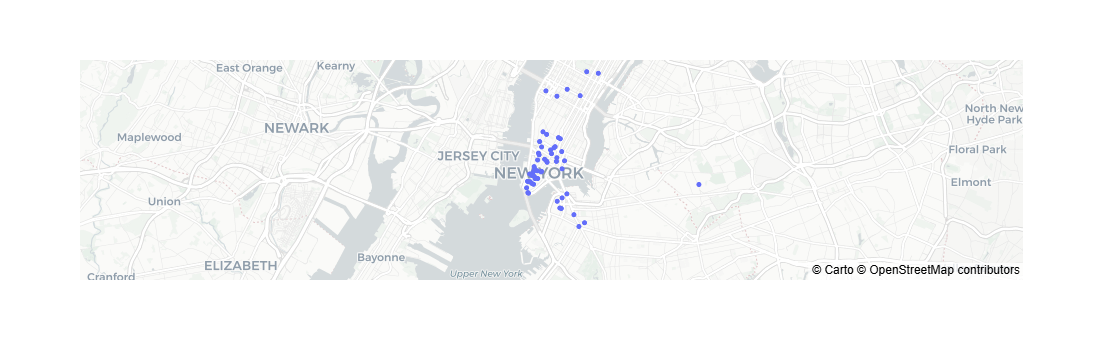

In [71]:

# Simple map to visualize subway stations and lat/lon coordinates. This looks ok, but it is way too basic, and it really doesn't add a whole 
# lot of value to the analysis. So, yeat again, we will test different solutions, and pick the best one.

import plotly.express as px
import pandas as pd


# Create Plotly figure
fig = px.scatter_mapbox(stations_df, lat='lat', lon='lng', hover_name='name',
                        hover_data=['name'],
                        zoom=10)

# Customize map layout
fig.update_layout(mapbox_style="carto-positron",
                  mapbox_zoom=10,
                  mapbox_center={"lat": stations_df['lat'].mean(), "lon": stations_df['lng'].mean()})

# Display the map
fig.show()


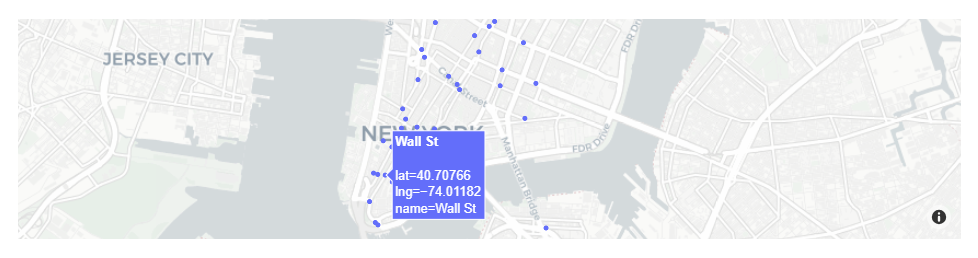

In [109]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "plotly_map.png")


In [ ]:

# This looks nice, but it's just a plot of subway stations and their latitude + longitude coordinates. In our dataset we do NOT
# have all the details of all the lat/lon coordinates between stations amd we can't interpolate them. Without the detailed path coordinates, 
# plotting a route between subway stations would result in straight lines between the points. So, the coordinates for the actual 
# subway paths would require detailed knowledge of the subway tracks or access to data that includes the precise paths the trains take.

# However, you can use Google's Directions API to get the detailed paths between the stations. This API can return a polyline representing 
# the path that can be decoded into a series of latitude and longitude points!! Very cool!!


In [128]:

# The code below hits the Google Places API to fetch data that allows up to simulate the path that the subway tracks follow. We don't have detailed
# data about all lat/lon coordinates that the subway tracks follow. We have lat/lon coordinates for subway stations only, and we can't interpolate
# the missing lat/lon coordinates -- it's impossible to do that.

import googlemaps
import pandas as pd
import folium
import polyline
from IPython.display import display

# Your Google Maps API key
API_KEY = 'your_api_key'

# Initialize the Google Maps client
gmaps = googlemaps.Client(key=API_KEY)

# Example optimized route, as derived above
optimized_route = [
    {'name': 'York St', 'lat': 40.701397, 'lng': -73.986751},
    {'name': 'East Broadway', 'lat': 40.713776, 'lng': -73.990215},
    {'name': 'Delancey St–Essex St', 'lat': 40.718693, 'lng': -73.988823},
    {'name': 'Grand St', 'lat': 40.718108, 'lng': -73.993621},
    {'name': 'Bowery', 'lat': 40.72028, 'lng': -73.993915},
    {'name': '2 Av', 'lat': 40.722714, 'lng': -73.989229},
    {'name': 'Astor Pl', 'lat': 40.730054, 'lng': -73.99107},
    {'name': '8 St-NYU', 'lat': 40.730636, 'lng': -73.992379},
    {'name': 'Bleecker St', 'lat': 40.725915, 'lng': -73.994659},
    {'name': 'Broadway-Lafayette St', 'lat': 40.725297, 'lng': -73.996204},
    {'name': 'Prince St', 'lat': 40.724329, 'lng': -73.997702},
    {'name': 'Brooklyn Bridge-City Hall', 'lat': 40.712812, 'lng': -74.004261},
    {'name': 'City Hall', 'lat': 40.713364, 'lng': -74.006828},
    {'name': 'Fulton St', 'lat': 40.710374, 'lng': -74.007582},
    {'name': 'Broad St', 'lat': 40.706476, 'lng': -74.011033},
    {'name': 'Wall St', 'lat': 40.707557, 'lng': -74.011862},
    {'name': 'Whitehall St-South Ferry', 'lat': 40.703087, 'lng': -74.013034},
    {'name': 'South Ferry', 'lat': 40.702147, 'lng': -74.013347},
    {'name': 'Bowling Green', 'lat': 40.704152, 'lng': -74.013984},
    {'name': 'Rector St', 'lat': 40.70774, 'lng': -74.013224},
    {'name': 'WTC Cortlandt', 'lat': 40.711835, 'lng': -74.012188},
    {'name': 'Cortlandt St', 'lat': 40.710668, 'lng': -74.011029},
    {'name': 'World Trade Center', 'lat': 40.711242, 'lng': -74.012177},
    {'name': 'Park Place', 'lat': 40.713051, 'lng': -74.008811},
    {'name': 'Chambers St', 'lat': 40.714316, 'lng': -74.008607},
    {'name': 'Franklin Street', 'lat': 40.719318, 'lng': -74.006886},
    {'name': 'Canal St', 'lat': 40.718092, 'lng': -74.000775},
    {'name': 'Spring St', 'lat': 40.722301, 'lng': -74.002988},
    {'name': 'Houston St', 'lat': 40.728251, 'lng': -74.005367},
    {'name': 'W 4 St-Wash Sq', 'lat': 40.732338, 'lng': -74.000496},
    {'name': 'Christopher St-Sheridan Sq', 'lat': 40.733659, 'lng': -74.003011},
    {'name': '34 St-Hudson Yards', 'lat': 40.755983, 'lng': -74.001364},
    {'name': '34 St - Penn Station', 'lat': 40.750373, 'lng': -73.991057},
    {'name': 'Times Sq–42 St', 'lat': 40.755290, 'lng': -73.987495},
    {'name': 'Grand Central-42 St', 'lat': 40.751776, 'lng': -73.977717},
    {'name': '5 Av/59 St', 'lat': 40.764811, 'lng': -73.973347},
    {'name': 'Lexington Av/63 St', 'lat': 40.764662, 'lng': -73.966993},
    {'name': 'Fresh Pond Rd', 'lat': 40.706231, 'lng': -73.895939},
    {'name': 'Fort Hamilton Pkwy', 'lat': 40.640912, 'lng': -73.994085},
    {'name': '36 St', 'lat': 40.655144, 'lng': -74.003549},
    {'name': 'Atlantic Av-Barclays Ctr', 'lat': 40.68446, 'lng': -73.977167},
    {'name': 'Lafayette Av', 'lat': 40.686113, 'lng': -73.973946},
    {'name': 'DeKalb Av', 'lat': 40.690635, 'lng': -73.981824},
    {'name': 'Borough Hall', 'lat': 40.693771, 'lng': -73.990433},
    {'name': 'Court St', 'lat': 40.694016, 'lng': -73.991440},
    {'name': 'Clark St', 'lat': 40.697466, 'lng': -73.993086},
    {'name': 'High St', 'lat': 40.699337, 'lng': -73.991839}
]

# Function to get the polyline for the path between two points
def get_polyline(start, end, api_key):
    directions_result = gmaps.directions(start, end, mode="transit", transit_mode="subway")
    if directions_result:
        polyline_str = directions_result[0]['overview_polyline']['points']
        return polyline.decode(polyline_str)
    else:
        return []

# Function to plot the entire route
def plot_optimized_route(optimized_route, api_key):
    # Create a Folium map centered around the first station
    first_station = optimized_route[0]
    map_center = (first_station['lat'], first_station['lng'])
    my_map = folium.Map(location=map_center, zoom_start=13)

    # Iterate through the optimized route and plot the path
    for i in range(len(optimized_route) - 1):
        start = (optimized_route[i]['lat'], optimized_route[i]['lng'])
        end = (optimized_route[i + 1]['lat'], optimized_route[i + 1]['lng'])
        path = get_polyline(start, end, api_key)
        
        if path:
            folium.PolyLine(locations=path, color='blue', weight=5, opacity=0.7).add_to(my_map)
        
        # Add markers for the start and end stations
        folium.Marker(location=start, popup=optimized_route[i]['name']).add_to(my_map)
        folium.Marker(location=end, popup=optimized_route[i + 1]['name']).add_to(my_map)

    # Display the map
    display(my_map)

# Plot the optimized route
plot_optimized_route(optimized_route, API_KEY)


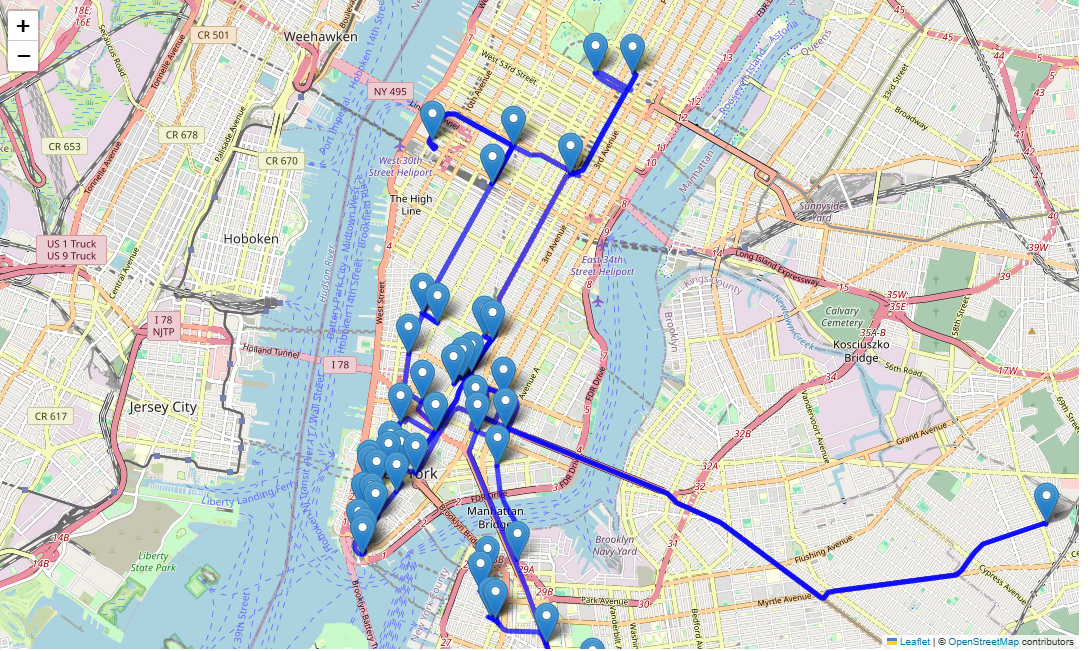

In [129]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "code_generated_map.png")


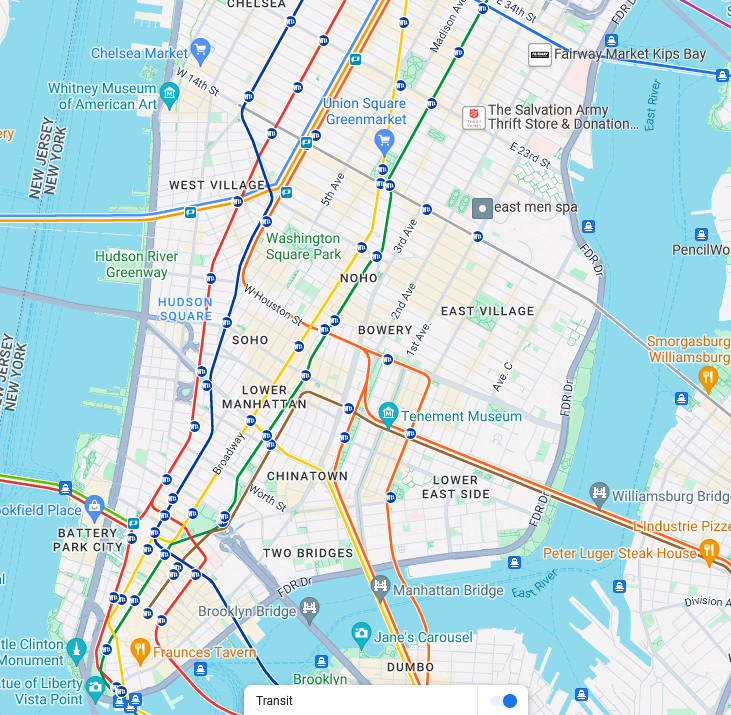

In [93]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "google_maps.png")


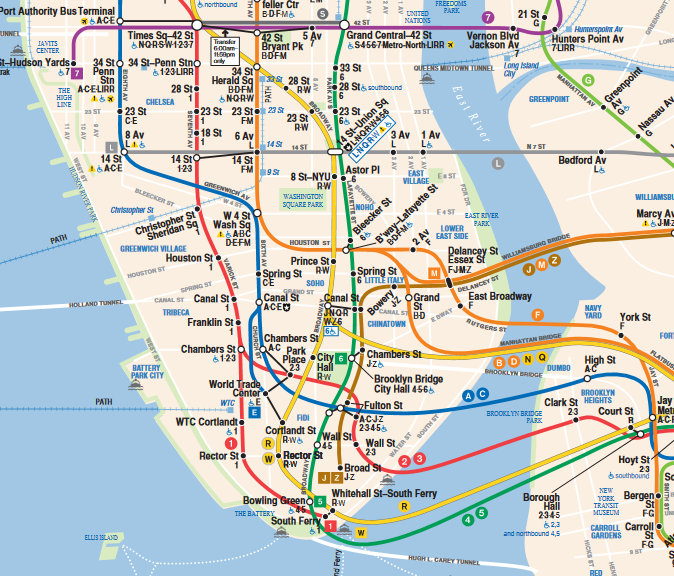

In [92]:

from IPython.display import Image
from IPython.core.display import HTML 
PATH = "C:\\Users\\ryan_\\Desktop\\"
Image(filename = PATH + "nyc_subway_map.png")


In [ ]:

# END!!! 
